In [79]:
# Program to calculate binary evolution from constant time lag formalism

import numpy as np
import rebound as rb
import reboundx as rx
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from scipy.integrate import odeint
from scipy.integrate import quad
import scipy
from scipy import integrate
import math as m
import random as rd
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pylab as pl

In [114]:
# Parameters for population of binaries circularized

nb = 1 # Choose 10^5 for my simulation, if you want to run a test, 
# change it to ~10^2-10^3, *much* faster 
age_min = 1. # Age bounds for my simulation, gives range of binary ages.  
# Want one value for your simulation
age_max = 10.

In [42]:
def N(e):
    num = 1. + 15./2.*e**2. + 45./8.*e**4. + 5./16.*e**6.
    den = (1.-e**2.)**6.
    return num/den

In [43]:
def Na(e):
    num = 1. + 31./2.*e**2. + 255./8.*e**4. + 185./16.*e**6. + 25./64.*e**8.
    den = (1.-e**2.)**(15./2.)
    return num/den

In [44]:
def Omegae(e):
    num = 1. + 3./2.*e**2. + 1./8.*e**4.
    den = (1.-e**2.)**5.
    return num/den

In [45]:
def Ne(e):
    num = 1. + 15./4.*e**2. + 15./8.*e**4. + 5./64.*e**6.
    den = (1.-e**2.)**(13./2.)
    return num/den

In [46]:
def Omega(e):
    num = 1. + 3.*e**2. + 3./8.*e**4.
    den = (1.-e**2.)**(9./2.)
    return num/den

In [47]:
def Fe(e):
    om_eq = N(e)/Omega(e)  # This is the "pseudo-synchronous" rotation
    return Omegae(e)*om_eq - 18./11.*Ne(e)

In [48]:
def Fa(e):
    om_eq = N(e)/Omega(e)  # This is the "pseudo-synchronous" rotation
    return 4./11.*(N(e)*om_eq - Na(e))

In [ ]:
"""# Ordinary differential equation integrate to get tidal evolution
# Parameters: 
# orb = (P[0],e[0]) initial orbital elements of binary
# time is time array you integrate simulation over
# mu is binary mass ratio M_2/M_1 *not* reduced mass
# eta is a powerlaw used for my problem, take out this parameter for your simulations"""

In [115]:
# Loading REBOUND  and REBOUNDx simulation archives
sim = None

sim = rx.SimulationArchive('eb0.525_ap4.500_Np15.0_tup25.0_Q10000.0_tau0.0030.bin', 
                           rebxfilename='xarchive.bin')

orb = []

for num in range(len(sim)):
    e = sim[num][0].particles[1].e
    a = sim[num][0].particles[1].a
    
    orb.append((a,e))
# print(orb)
k_2 = sim[0][0].particles[0].params["tctl_k1"] # 0.035 for primary binary
tau = sim[0][0].particles[0].params["tctl_tau"] # 3.03E-5

M1 = 1
M2 = 1
mu = 0.5
G = 6.67E-11
R_star = 0.1*(1-0.5)**(1/3) # (1-mu)

In [116]:
# Creating population of binaries to circularize
mu_pop = 0.5

eb_pop = sim[0][0].particles[1].e

ab_min=1.
ab_max=200.

xmin = np.log(ab_min)
xmax = np.log(ab_max)

lam = np.random.power(2.,size=nb)

x_pop = (1.-lam)*xmin + lam*xmax

ab_pop = sim[0][0].particles[1].a
age_pop = sim[62][0].t

In [117]:
def TideEq(orb,time,mu):
        
    ab = orb[0] # Semi-major axis
    eb = orb[1] # Eccentricity
        
    K = ((3/2)*(nb**2)*k_2*tau)*((G*M1**2)/R_star)*((M2/M1)**2)*(R_star/ab)**6
    dedt = ((11*eb*ab*K)/(G*M1*M2))*(Omegae(eb)*(Omega(eb)/nb)-(18/11)*Ne(eb)) # differential equation for eccentricity
    dadt = ((4*K*ab**2)/(G*M1*M2))*(N(eb)*(Omega(eb)/nb)-Na(eb)) # Differential equation for semi-major axis
        
        #tc = (eb*mu*(1+mu))/((dedt)*(Fe(eb))) # circularization timescale
    
    return [dadt,dedt] # Returns differential equation for a and e

In [127]:
ab_ev = []
eb_ev = []
ab_0 = []
eb_0 = [] 
mu_ev = []
age_ev = []

for i in range(nb):
    # Individual parameters saving for circularized population of binaries
    ab = ab_pop
    eb = eb_pop
    
    mub = mu_pop
    ageb = age_pop

    # This is where I tidally-circularize the population, you will likely want to do this for only one binary at a time
    
    tb = np.linspace(0.,10.,num=(100))				# Array of times to calculate ODE over
    orbb = (orb[0][0],orb[0][1]) # of the form (ab,eb)			# Initializing orbital elements
    solb = odeint(TideEq, orbb, tb, args=(mub,))		# Saving the time evolution of the arrays
    
    # Here, I save *only* the endpoint of the simulation.  You will likely want to keep the full time evolution
    
    if solb[-1,0] > 0. and solb[-1,1]<1 and isinstance(solb[-1,0],float) and isinstance(solb[-1,1],float):
        
        ab_ev.append(solb[:,0])
        eb_ev.append(solb[:,1])
        ab_0.append(solb[:,0]) 
        eb_0.append(solb[:,1]) 
        mu_ev.append(mub)
        age_ev.append(ageb)

Text(0.5, 1.0, 'Binary Eccentricity Evolution')

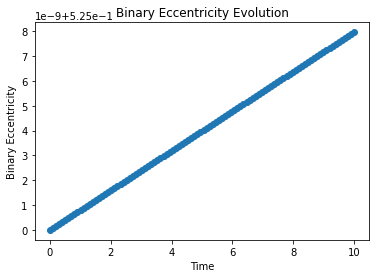

In [130]:
fig = plt.figure()
plt.scatter(tb, eb_ev)
plt.xlabel("Time")
plt.ylabel("Binary Eccentricity")
plt.title("Binary Eccentricity Evolution")

Text(0.5, 1.0, 'Binary Semi-Major Axis Evolution')

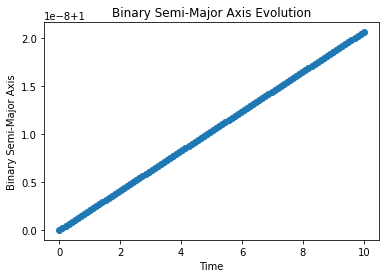

In [131]:
fig = plt.figure()
plt.scatter(tb, ab_ev)
plt.xlabel("Time")
plt.ylabel("Binary Semi-Major Axis")
plt.title("Binary Semi-Major Axis Evolution")